In [121]:
import numpy as np
import pandas as pd

from datetime import datetime,timedelta

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings

import matplotlib.pyplot as plt
import matplotlib as mpl
filterwarnings('ignore')
mpl.rcParams['lines.linewidth'] = 1
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (15,7)})

In [122]:
lstm_train = pd.read_csv("preds/ensemble/DL train preds.csv")
lstm_val = pd.read_csv("preds/ensemble/DL val conf.csv")
lstm_test = pd.read_csv("preds/ensemble/DL test conf.csv")

es_train = pd.read_csv("preds/ensemble/es train preds.csv")
es_test = pd.read_csv("preds/ensemble/es test_preds.csv")

df = pd.read_csv("dataset/ngp.csv")

In [123]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
5518,2022-08-19,9.395,8.870,9.201,9.336,69809.0,9.336
5519,2022-08-22,9.982,9.158,9.174,9.680,92412.0,9.680
5520,2022-08-23,10.028,9.050,9.817,9.193,118634.0,9.193
5521,2022-08-24,9.455,9.100,9.250,9.330,118634.0,9.330
5522,2022-08-25,9.419,9.175,9.239,9.369,23793.0,9.369


In [124]:
start = datetime(2000,8,30)
end = datetime(2022,8,25)

In [125]:
dates = pd.date_range(start, end).to_frame(name='Date')

In [126]:
df['Date'] = pd.to_datetime(df['Date'])

In [127]:
df_full = pd.merge(dates, df, how='left', on='Date')

In [128]:
rolling_mean = df_full["Close"].rolling(2).mean()

In [129]:
data = df_full.set_index('Date')

In [130]:
y = data['Close']
y_idx = y.index

In [131]:
y = y.values

In [132]:
for i in range(len(y)):
    if np.isnan(y[i]):
        y[i]= rolling_mean[i]

In [133]:
y_true = pd.Series(y, index=y_idx)

In [134]:
y_true = y_true.ffill()

In [135]:
train_end = datetime(2020,12,31)

In [136]:
y_train_true = y_true[:train_end]

In [137]:
y_test_true = y_true[train_end+timedelta(1):]

In [138]:
lstm_test = pd.concat([lstm_val, lstm_test]).reset_index(drop=True).rename(columns={'Unnamed: 0':'Date'}).set_index('Date')

In [139]:
es_test.index = lstm_test.index

In [140]:
lstm_train.shape, es_train.shape

((7408, 2), (7429, 2))

In [141]:
es_train = es_train[21:]

In [142]:
lstm_train.rename(columns={'0':'price'}, inplace=True)

In [143]:
es_train.rename(columns={'0':'price'}, inplace=True)

In [144]:
train_data = pd.merge(lstm_train, es_train, left_on="Date", right_on='All_date', suffixes=('_lstm', '_exp'))

## Train Data

In [145]:
X_train = train_data[['price_lstm', 'price_exp']]

In [178]:
X_train

,price_lstm,price_exp
0,5.274950,5.335714
1,5.260453,5.332494
2,5.239125,5.267798
3,5.118158,5.164458
4,5.158888,5.240956
...,...,...
7403,2.552990,2.622852
7404,2.543024,2.586819
7405,2.393087,2.346026
7406,2.424871,2.448767


In [146]:
y_train = y_train_true[train_data.Date]

In [179]:
y_train

Date
2000-09-20    5.320
2000-09-21    5.287
2000-09-22    5.131
2000-09-23    5.131
2000-09-24    5.131
              ...  
2020-12-27    2.518
2020-12-28    2.305
2020-12-29    2.467
2020-12-30    2.422
2020-12-31    2.539
Length: 7408, dtype: float64

## Test Data

In [147]:
lstm_test

,Predictions,Lower Bound,Upper Bound
Date,,,
2021-01-04,2.489157,0.383438,4.594876
2021-01-05,2.508520,0.402801,4.614239
2021-01-06,2.479819,0.374100,4.585538
2021-01-07,2.623853,0.518134,4.729572
2021-01-08,2.601787,0.496068,4.707506
...,...,...,...
2022-08-19,10.649662,6.261897,15.037427
2022-08-22,10.657714,6.269949,15.045479
2022-08-23,10.902489,6.514724,15.290254


In [148]:
test_data = pd.merge(es_test[["simulation"]], lstm_test['Predictions'], left_on=es_test.index, right_on=lstm_test.index)

In [149]:
X_test = test_data[['simulation', 'Predictions']]

In [150]:
y_test = y_true[test_data['key_0']]

In [151]:
lr = LinearRegression()

In [152]:
lr.fit(X_train, y_train)

LinearRegression()

In [153]:
lr.score(X_test, y_test)

0.9505003371926022

In [154]:
y_train_preds = lr.predict(X_train)

In [155]:
y_train_preds = pd.Series(y_train_preds, index=y_train.index)

In [156]:
train_mse = mean_squared_error(y_train_preds,y_train)
print(f"Train MSE={train_mse}, RMSE={np.sqrt(train_mse)}")

Train MSE=0.025138183576122596, RMSE=0.1585502556797768


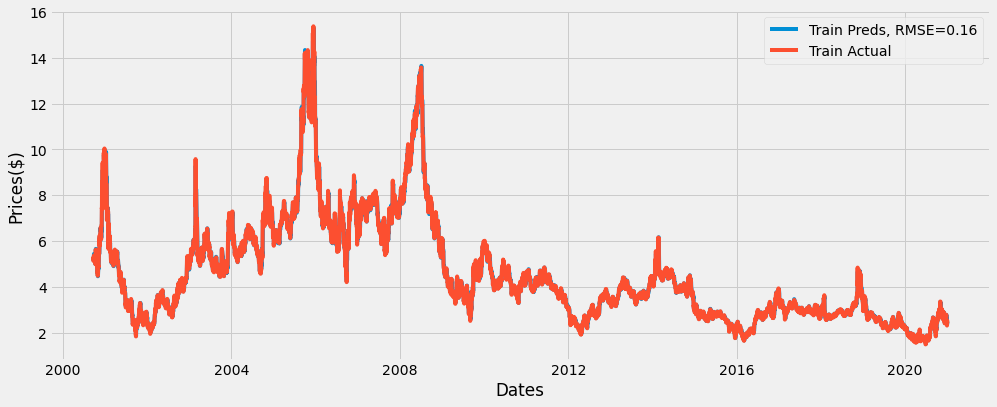

In [157]:
plt.figure(figsize=(15,6))
plt.plot(y_train_preds, label="Train Preds, RMSE={}".format(round(np.sqrt(train_mse),2)))
plt.plot(y_train, label="Train Actual")
plt.xlabel("Dates")
plt.ylabel("Prices($)")
plt.legend()
plt.show()

In [158]:
y_test_preds = lr.predict(X_test)

In [159]:
test_mse = mean_squared_error(y_test_preds,y_test)
print(f"Train MSE={test_mse}, RMSE={np.sqrt(test_mse)}")

Train MSE=0.18048979497852205, RMSE=0.4248409054911286


In [160]:
y_test_preds = pd.Series(y_test_preds, index=y_test.index)

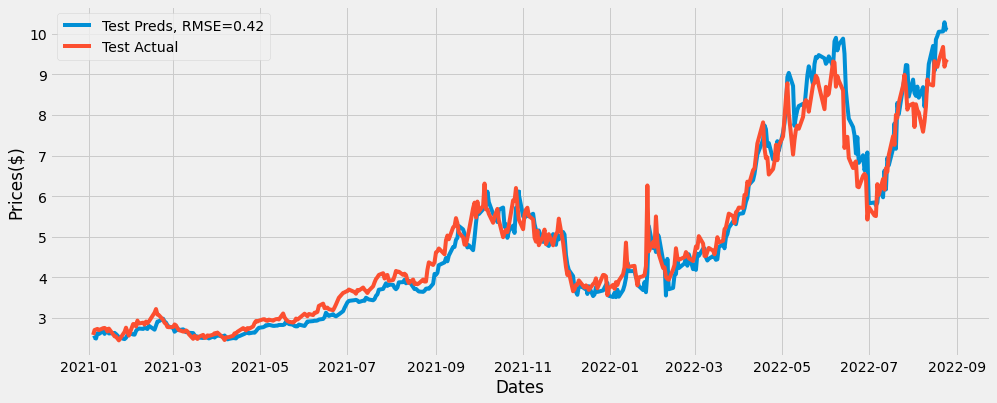

In [161]:
plt.figure(figsize=(15,6))
plt.plot(y_test_preds, label="Test Preds, RMSE={}".format(round(np.sqrt(test_mse),2)))
plt.plot(y_test, label="Test Actual")
plt.xlabel("Dates")
plt.ylabel("Prices($)")
plt.legend()
plt.show()

In [162]:
mse = mean_squared_error(X_train.mean(axis=1),y_train)
mse, np.sqrt(mse)

(0.02664279393433914, 0.16322620480284145)

## 5 years

In [163]:
lstm_5 = pd.read_csv("preds/ensemble/DL(LSTM) complete preds.csv")

In [164]:
exp_5 = pd.read_csv("preds/ensemble/Exponential Smoothing.csv")

In [165]:
lstm_5['Date'] = pd.to_datetime(lstm_5['Date'])

In [166]:
lstm5pred = lstm_5.set_index("Date")["Predictions"]

In [167]:
exp_5.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

In [168]:
exp_5['Date'] = pd.to_datetime(exp_5['Date'])

In [169]:
exp5pred = exp_5.set_index("Date")["Predictions"]

In [170]:
years_5 = pd.merge(lstm5pred,exp5pred, on='Date')

In [171]:
X_5 = years_5.values

In [172]:
preds_5 = lr.predict(X_5)
preds_5

array([11.65462618, 11.6714891 , 11.61851578, ..., 10.79479396,
       10.81768704, 10.76843499])

In [173]:
len(preds_5)

1827

In [174]:
start = datetime(2021,1,1)

In [175]:
dates = pd.date_range(start=start, end = start+timedelta(len(preds_5)-1))

In [176]:
preds = pd.Series(preds_5, index=dates)

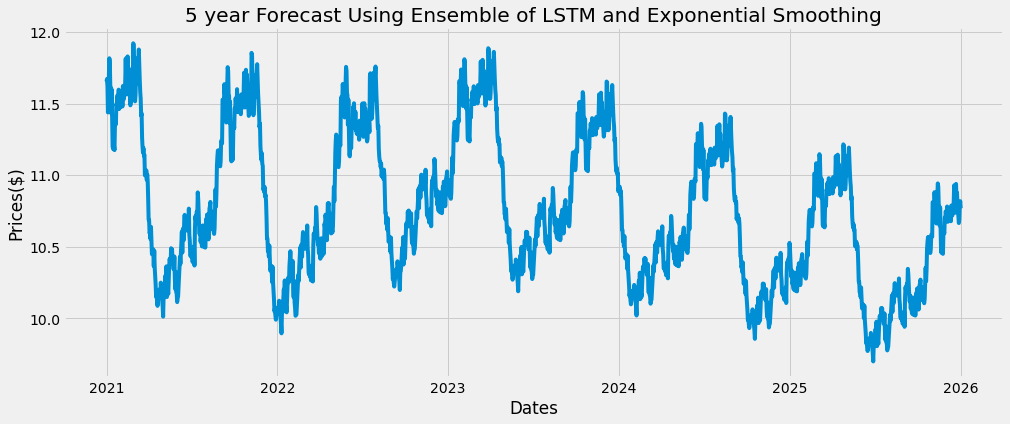

In [177]:
plt.figure(figsize=(15,6))
plt.plot(preds)
plt.title("5 year Forecast Using Ensemble of LSTM and Exponential Smoothing")
plt.xlabel("Dates")
plt.ylabel("Prices($)")
plt.show()

In [180]:
preds[datetime(2023, 8,25)]

10.550979586767452

In [181]:
preds[datetime(2025, 8,25)]

10.006456625274362

In [182]:
preds[datetime(2024, 8,25)]

11.278666923775802

In [184]:
preds[datetime(2026, 1,1)]

10.768434989636372

In [103]:
preds.to_csv("Ensemble preds5.csv", index=False)

## Random forest

In [105]:
rf = RandomForestRegressor(n_jobs=-1)

In [106]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [107]:
rf.score(X_test, y_test)

0.9186035133622832

In [108]:
y_train_preds = rf.predict(X_train)

In [109]:
y_train_preds = pd.Series(y_train_preds, index=y_train.index)

In [110]:
train_mse = mean_squared_error(y_train_preds,y_train)
print(f"Train MSE={train_mse}, RMSE={np.sqrt(train_mse)}")

Train MSE=0.004487318207783976, RMSE=0.06698744813607976


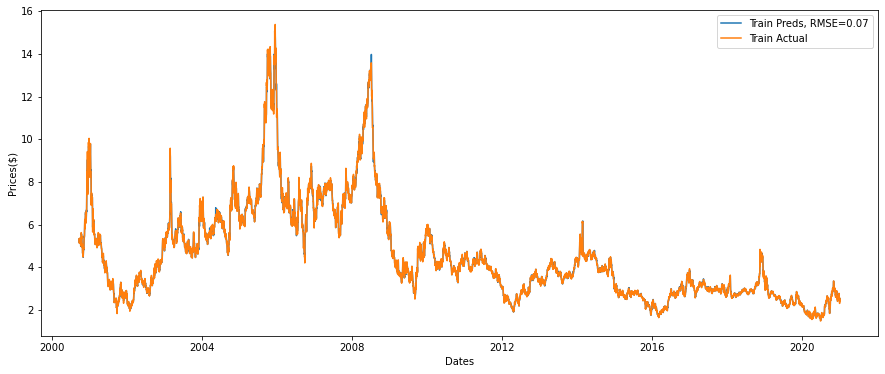

In [111]:
plt.figure(figsize=(15,6))
plt.plot(y_train_preds, label="Train Preds, RMSE={}".format(round(np.sqrt(train_mse),2)))
plt.plot(y_train, label="Train Actual")
plt.xlabel("Dates")
plt.ylabel("Prices($)")
plt.legend()
plt.show()

In [112]:
y_test_preds = rf.predict(X_test)

In [113]:
test_mse = mean_squared_error(y_test_preds,y_test)
print(f"Train MSE={test_mse}, RMSE={np.sqrt(test_mse)}")

Train MSE=0.29679465176110004, RMSE=0.544788630352268


In [114]:
y_test_preds = pd.Series(y_test_preds, index=y_test.index)

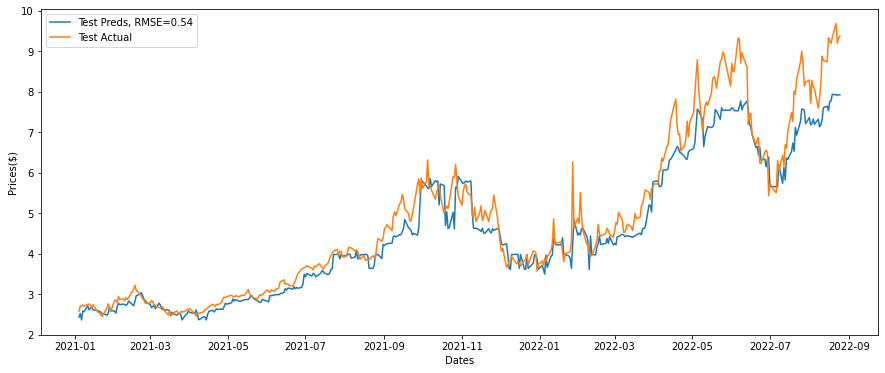

In [115]:
plt.figure(figsize=(15,6))
plt.plot(y_test_preds, label="Test Preds, RMSE={}".format(round(np.sqrt(test_mse),2)))
plt.plot(y_test, label="Test Actual")
plt.xlabel("Dates")
plt.ylabel("Prices($)")
plt.legend()
plt.show()

In [56]:
mse = mean_squared_error(X_train.mean(axis=1),y_train)
mse, np.sqrt(mse)

(0.02664279393433914, 0.16322620480284145)